In [1]:
!nvidia-smi

Fri Mar  4 08:54:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.52       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  ERR!                On   | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P3    N/A /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#!cp /content/drive/MyDrive/Object_detection/dataset.zip dataset.zip
#!cp /content/drive/MyDrive/Object_detection/test.zip test.zip

In [4]:
#!unzip -q dataset.zip -d /content/dataset
#!unzip -q test.zip -d /content/test

In [1]:
train_folder = './images/train'
test_folder = './images/test'

In [2]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim

# Functions

In [3]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x.permute(1, 2, 0).numpy())
        plt.grid(False)
        plt.axis('off')   

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [4]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    accuracy = 0
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
      for _, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        indices = torch.argmax(pred, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        accuracy = float(correct_samples) / total_samples
    return accuracy

In [5]:
def train_model_with_annealing(model, train_loader, val_loader, loss, 
                               optimizer, num_epochs, sheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        sheduler.step()

        print("Epoch %i. Average loss: %f, Train accuracy: %f, Val accuracy: %f"
         % (epoch+1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

# First try

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(train_folder, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_folder, test_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


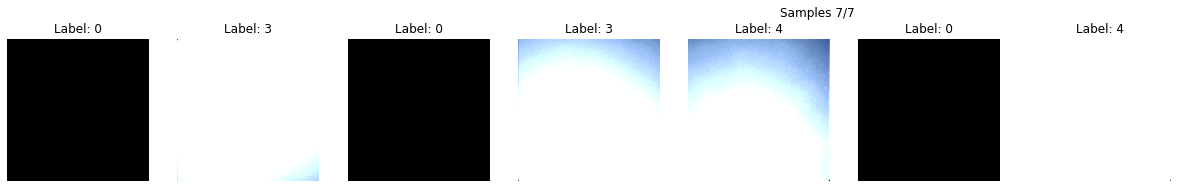

In [ ]:
indices = np.random.choice(np.arange(len(dataset)), 7, replace=False)

visualize_samples(dataset, indices, "Samples")

In [ ]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(127)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
    

In [ ]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
loss_history, train_history, val_history = train_model(model, train_loader, 
                                                       val_loader, loss, 
                                                       optimizer, 10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Average loss: 0.859468, Train accuracy: 0.652865, Val accuracy: 0.741259
Average loss: 0.590485, Train accuracy: 0.765024, Val accuracy: 0.796503
Average loss: 0.529226, Train accuracy: 0.785989, Val accuracy: 0.802098
Average loss: 0.477485, Train accuracy: 0.807128, Val accuracy: 0.811888
Average loss: 0.455366, Train accuracy: 0.811321, Val accuracy: 0.817483
Average loss: 0.452141, Train accuracy: 0.820231, Val accuracy: 0.834965
Average loss: 0.432685, Train accuracy: 0.818484, Val accuracy: 0.853147
Average loss: 0.416413, Train accuracy: 0.827044, Val accuracy: 0.826573
Average loss: 0.429418, Train accuracy: 0.814291, Val accuracy: 0.818881
Average loss: 0.410706, Train accuracy: 0.829140, Val accuracy: 0.837063


In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
loss_history, train_history, val_history = train_model(model, train_loader, 
                                                       val_loader, loss, 
                                                       optimizer, 10)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Average loss: 0.759255, Train accuracy: 0.689378, Val accuracy: 0.739860
Average loss: 0.545474, Train accuracy: 0.772187, Val accuracy: 0.738462
Average loss: 0.486378, Train accuracy: 0.790531, Val accuracy: 0.790210
Average loss: 0.490435, Train accuracy: 0.789658, Val accuracy: 0.802098
Average loss: 0.449821, Train accuracy: 0.809574, Val accuracy: 0.845455
Average loss: 0.440056, Train accuracy: 0.810622, Val accuracy: 0.818881
Average loss: 0.425583, Train accuracy: 0.822502, Val accuracy: 0.810490
Average loss: 0.411134, Train accuracy: 0.826171, Val accuracy: 0.802797
Average loss: 0.404722, Train accuracy: 0.827044, Val accuracy: 0.824476
Average loss: 0.403421, Train accuracy: 0.828791, Val accuracy: 0.783217


# Transforms with rotation, no color jitter.

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(train_folder, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_folder, test_transforms)

In [11]:
batch_size = 32

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(127)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# batch_size=128
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.969101, Train accuracy: 0.599231, Val accuracy: 0.693706
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.722501, Train accuracy: 0.685884, Val accuracy: 0.702098
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.662014, Train accuracy: 0.710867, Val accuracy: 0.713287
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.624657, Train accuracy: 0.728686, Val accuracy: 0.747552
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5. Average loss: 0.605732, Train accuracy: 0.728512, Val accuracy: 0.727972
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6. Average loss: 0.595996, Train accuracy: 0.732355, Val accuracy: 0.744056
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7. Average loss: 0.578293, Train accuracy: 0.746681, Val accuracy: 0.717483
Adjusting learning rate of

In [12]:
# batch_size=32
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.753572, Train accuracy: 0.689727, Val accuracy: 0.783916
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.546468, Train accuracy: 0.758910, Val accuracy: 0.783217
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.478132, Train accuracy: 0.793501, Val accuracy: 0.827972
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.476294, Train accuracy: 0.796296, Val accuracy: 0.831469
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5. Average loss: 0.461155, Train accuracy: 0.803110, Val accuracy: 0.838462
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6. Average loss: 0.444732, Train accuracy: 0.804158, Val accuracy: 0.833566
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7. Average loss: 0.437350, Train accuracy: 0.816562, Val accuracy: 0.816084
Adjusting learning rate of

In [12]:
# batch_size=32
model = models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.660249, Train accuracy: 0.721873, Val accuracy: 0.820979
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.482008, Train accuracy: 0.788784, Val accuracy: 0.839161
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.456821, Train accuracy: 0.801188, Val accuracy: 0.843357
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.453060, Train accuracy: 0.806080, Val accuracy: 0.858042
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5. Average loss: 0.446318, Train accuracy: 0.806429, Val accuracy: 0.836364
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6. Average loss: 0.413352, Train accuracy: 0.826520, Val accuracy: 0.803497
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7. Average loss: 0.384553, Train accuracy: 0.837352, Val accuracy: 0.862238
Adjusting learning rate of

In [15]:
# batch_size=32
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.738050, Train accuracy: 0.688505, Val accuracy: 0.804895
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.527249, Train accuracy: 0.775507, Val accuracy: 0.837063
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.509860, Train accuracy: 0.776555, Val accuracy: 0.774126
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.454378, Train accuracy: 0.801013, Val accuracy: 0.808392
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 5. Average loss: 0.450875, Train accuracy: 0.809399, Val accuracy: 0.804895
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 6. Average loss: 0.433490, Train accuracy: 0.816737, Val accuracy: 0.820979
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 7. Average loss: 0.416844, Train accuracy: 0.822676, Val accuracy: 0.846853
Adjusting learning rate of

In [19]:
# batch_size=32
model = models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.566681, Train accuracy: 0.763627, Val accuracy: 0.851049
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.404395, Train accuracy: 0.835779, Val accuracy: 0.891608
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.342773, Train accuracy: 0.863208, Val accuracy: 0.896503
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.341999, Train accuracy: 0.858665, Val accuracy: 0.899301
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 5. Average loss: 0.331596, Train accuracy: 0.869672, Val accuracy: 0.904196
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 6. Average loss: 0.296759, Train accuracy: 0.882250, Val accuracy: 0.902797
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 7. Average loss: 0.287044, Train accuracy: 0.889064, Val accuracy: 0.914685
Adjusting learning rate of

In [17]:
from torch.nn.modules.container import Sequential
# batch_size=32
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.639721, Train accuracy: 0.768344, Val accuracy: 0.888811
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.403543, Train accuracy: 0.858316, Val accuracy: 0.902098
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.347694, Train accuracy: 0.871419, Val accuracy: 0.918182
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.306523, Train accuracy: 0.887666, Val accuracy: 0.921678
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 5. Average loss: 0.297233, Train accuracy: 0.892383, Val accuracy: 0.928671
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 6. Average loss: 0.274150, Train accuracy: 0.899895, Val accuracy: 0.924476
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 7. Average loss: 0.283086, Train accuracy: 0.889937, Val accuracy: 0.929371
Adjusting learning rate of

In [19]:
from torch.nn.modules.container import Sequential
# batch_size=32
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1. Average loss: 0.361277, Train accuracy: 0.864955, Val accuracy: 0.929371
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2. Average loss: 0.162996, Train accuracy: 0.934661, Val accuracy: 0.950350
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3. Average loss: 0.148354, Train accuracy: 0.942173, Val accuracy: 0.959441
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4. Average loss: 0.103428, Train accuracy: 0.960692, Val accuracy: 0.939161
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 5. Average loss: 0.083502, Train accuracy: 0.965584, Val accuracy: 0.969231
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 6. Average loss: 0.069077, Train accuracy: 0.972572, Val accuracy: 0.976923
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch 7. Average loss: 0.054266, Train accuracy: 0.976415, Val accuracy: 0.965035
Adjusting learning rate of

# EfficientNet-b0
## Dataset without vertical flip

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(train_folder, train_transforms)

In [7]:
batch_size = 32

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(127)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [8]:
from torch.nn.modules.container import Sequential
# batch_size=32
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    model, train_loader, val_loader, loss, optimizer, 5,
    sheduler)

Adjusting learning rate of group 0 to 1.0000e-03.


RuntimeError: CUDA error: CUBLAS_STATUS_INTERNAL_ERROR when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [13]:
from torch.nn.modules.container import Sequential
# batch_size=32
effnet_b3 = models.efficientnet_b3(pretrained=True)

for param in effnet_b3.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
effnet_b3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True)
)
effnet_b3 = effnet_b3.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(effnet_b3.parameters(),
    lr=1e-3) #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, 
                                     verbose=True)
loss_history, train_history, val_history = train_model_with_annealing(
    effnet_b3, train_loader, val_loader, loss, optimizer, 10,
    sheduler)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Test model

In [16]:
def evaluate_model_test(model, dataset):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    ground_truth = []
    predictions = []
    with torch.no_grad():
      loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
      
      for i_step, (x, y) in enumerate(loader):    
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred = model(x_gpu)
        res = torch.argmax(pred, 1)
        predictions.append(res)
        ground_truth.append(y_gpu)
      
      predictions = torch.cat(predictions)
      ground_truth = torch.cat(ground_truth)
    return predictions.cpu().detach().numpy(), ground_truth.cpu().detach().numpy()


In [17]:
batch_size = 32

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = torchvision.datasets.ImageFolder(test_folder, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [18]:
#predictions, ground_truth = evaluate_model_test(model, test_dataset)
accuracy = compute_accuracy(effnet_b3, test_loader)

In [19]:
print('Accuracy on test dataset', accuracy)

Accuracy on test dataset 0.764763779527559
